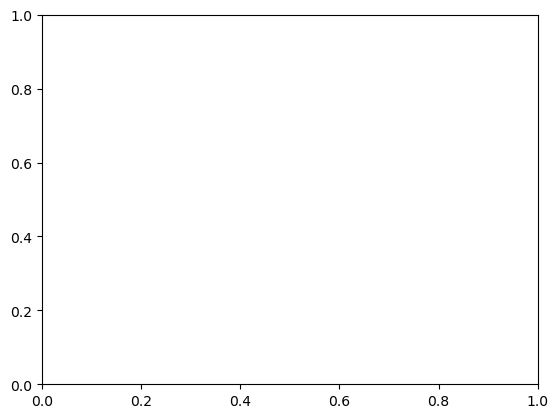

c:\Users\jaime\anaconda3\envs\ML_Playground_1\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


cuda


In [2]:
from conway_lib import ConwayGame, Tokenizer, ConwayModel
conway_game = ConwayGame()
import os
import torch
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import numpy as np
import random
import typing
import matplotlib.pyplot as plt

# Function to clear CUDA cache
def empty_cuda_cache():
    torch.cuda.empty_cache()

# Ensure Torch is using Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def count_mismatches(ground_truth, pred):
        mismatches = sum(1 for gt, p in zip(ground_truth, pred) if gt != p)
        accuracy = 1 - mismatches / len(ground_truth)
        return mismatches, accuracy

def extract_sample(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def extract_task(string_input, end_task_token='>'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

# Function to load the model
def load_model(model_path, max_length, num_words):
    empty_cuda_cache()
    
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print(f"Model loaded from {model_path}")
    
    return model

# Define Tokenizer class
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts: torch.Tensor, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

# Define function to generate validation data
def generate_validation_data(gridwidth, conway_game, val_size, s, e):
    validation_data = conway_game.generate_validation_sets(A=val_size, N=gridwidth, I=2, s=s, e=e)
    X_data_val = ["@PredictNextState<" + state[0] + "> [" + state[1] + "]$" for state in validation_data]
    return X_data_val, np.linspace(s, e, val_size)

# Define function to test the model on validation data
def test_model(model, tokenizer, X_data_val):
    model.eval()
    results = []
    total_accuracy = 0
    num_samples = len(X_data_val)
    accuracies = []
    
    for counter, val in enumerate(X_data_val, 1):
        print(counter)
        ground_truth = extract_sample(val)
        task = extract_task(val)
        inp = torch.Tensor(tokenizer.texts_to_sequences(task, do_padding=False)).to(device)
        inp = inp.transpose(0, 1)
        inp = inp.long()
        
        with torch.no_grad():
            sample = model.generate(
                prompts=inp,
                seq_len=generate_length,
                cache_kv=True
            )
        
        try:
            output_str = tokenizer.sequences_to_texts(sample[:1])
            pred = extract_sample(output_str[0])
            mismatches, accuracy = count_mismatches(ground_truth, pred)
            print(f"Accuracy for val sample {counter} is {accuracy}.")
            total_accuracy += accuracy
            accuracies.append(accuracy)
            results.append((val, output_str[0], accuracy))
        except Exception as e:
            print(f"Error decoding output: {e}")
            accuracies.append(0)
            results.append((val, "Error decoding output", 0))
    
    overall_accuracy = total_accuracy / num_samples
    return results, overall_accuracy, accuracies

## 32 x 32 grid high entropy data testing of broad data

In [50]:

model_path = "C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\08_14_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_Off_High_Entrpoy_Homog_2024-08-14 12-24-10\\LifeGPT_epoch_16.pt"
max_length = len("@PredictNextState<> []$") + (32*32*2)
generate_length = max_length - len("@PredictNextState<>") - (32 * 32)

# Load the model
model = load_model(model_path, max_length, num_words)

# Initialize tokenizer
tokenizer = Tokenizer(max_length, device)

Model loaded from C:\Users\jaime\ML_Playground_1\model_parameters\08_14_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_Off_High_Entrpoy_Homog_2024-08-14 12-24-10\Conway_GPT_v7_epoch_16.pt


In [51]:
#Generate validation data (Assuming `conway_game` is defined elsewhere and imported)
val_size = 110  # Adjust this value as needed
s, e = 0, 1
gridwidth = 32
X_data_test_2, order_params_2 = generate_validation_data(gridwidth, conway_game, val_size, s, e)

In [52]:
print(order_params_2)

[0.         0.00917431 0.01834862 0.02752294 0.03669725 0.04587156
 0.05504587 0.06422018 0.0733945  0.08256881 0.09174312 0.10091743
 0.11009174 0.11926606 0.12844037 0.13761468 0.14678899 0.1559633
 0.16513761 0.17431193 0.18348624 0.19266055 0.20183486 0.21100917
 0.22018349 0.2293578  0.23853211 0.24770642 0.25688073 0.26605505
 0.27522936 0.28440367 0.29357798 0.30275229 0.31192661 0.32110092
 0.33027523 0.33944954 0.34862385 0.35779817 0.36697248 0.37614679
 0.3853211  0.39449541 0.40366972 0.41284404 0.42201835 0.43119266
 0.44036697 0.44954128 0.4587156  0.46788991 0.47706422 0.48623853
 0.49541284 0.50458716 0.51376147 0.52293578 0.53211009 0.5412844
 0.55045872 0.55963303 0.56880734 0.57798165 0.58715596 0.59633028
 0.60550459 0.6146789  0.62385321 0.63302752 0.64220183 0.65137615
 0.66055046 0.66972477 0.67889908 0.68807339 0.69724771 0.70642202
 0.71559633 0.72477064 0.73394495 0.74311927 0.75229358 0.76146789
 0.7706422  0.77981651 0.78899083 0.79816514 0.80733945 0.816513

1
Accuracy for val sample 1 is 0.8994140625.
2
Accuracy for val sample 2 is 0.88671875.
3
Accuracy for val sample 3 is 0.875.
4
Accuracy for val sample 4 is 0.8701171875.
5
Accuracy for val sample 5 is 0.8564453125.
6
Accuracy for val sample 6 is 0.8427734375.
7
Accuracy for val sample 7 is 0.806640625.
8
Accuracy for val sample 8 is 0.78515625.
9
Accuracy for val sample 9 is 0.7890625.
10
Accuracy for val sample 10 is 0.7587890625.
11
Accuracy for val sample 11 is 0.7607421875.
12
Accuracy for val sample 12 is 0.70703125.
13
Accuracy for val sample 13 is 0.767578125.
14
Accuracy for val sample 14 is 0.72265625.
15
Accuracy for val sample 15 is 0.681640625.
16
Accuracy for val sample 16 is 0.7392578125.
17
Accuracy for val sample 17 is 0.671875.
18
Accuracy for val sample 18 is 0.6708984375.
19
Accuracy for val sample 19 is 0.7109375.
20
Accuracy for val sample 20 is 0.6318359375.
21
Accuracy for val sample 21 is 0.724609375.
22
Accuracy for val sample 22 is 0.724609375.
23
Accuracy fo

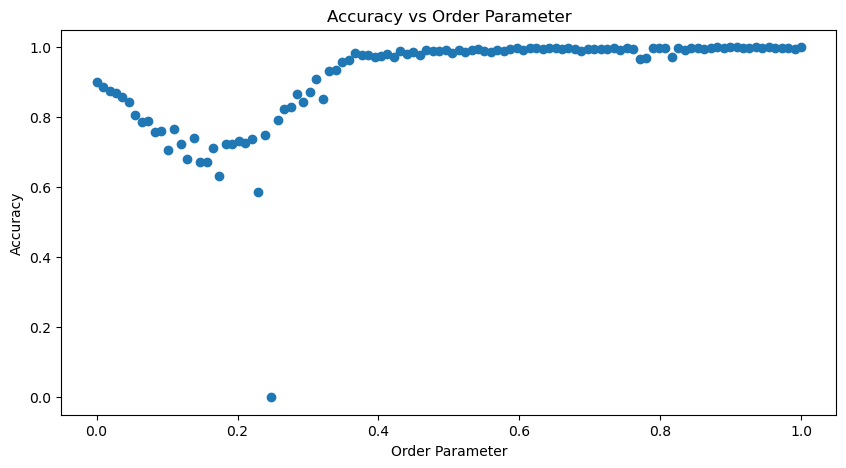

In [53]:
# Test the model on validation data
results_2, overall_accuracy_2, accuracies_2 = test_model(model, tokenizer, X_data_test_2)

# Print the results and overall accuracy
for val, output, accuracy in results_2:
    print(f"Input: {val}\nOutput: {output}\nAccuracy: {accuracy}\n")

print(f"Overall Accuracy: {overall_accuracy_2}")

# Plot accuracy vs order parameter
plt.figure(figsize=(10, 5))
plt.scatter(order_params_2, accuracies_2)
plt.xlabel('Order Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Order Parameter')
plt.show()

## Epoch 50 -- High Ent Training Data

Model loaded from C:\Users\jaime\ML_Playground_1\model_parameters\08_14_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_Off_High_Entrpoy_Homog_2024-08-14 12-24-10\Conway_GPT_v7_epoch_50.pt
1
Accuracy for val sample 1 is 0.9677734375.
2
Accuracy for val sample 2 is 0.9140625.
3
Accuracy for val sample 3 is 0.888671875.
4
Accuracy for val sample 4 is 1.0.
5
Accuracy for val sample 5 is 0.810546875.
6
Accuracy for val sample 6 is 0.9990234375.
7
Accuracy for val sample 7 is 0.9990234375.
8
Accuracy for val sample 8 is 0.9990234375.
9
Accuracy for val sample 9 is 0.9990234375.
10
Accuracy for val sample 10 is 0.7880859375.
11
Accuracy for val sample 11 is 0.7451171875.
12
Accuracy for val sample 12 is 0.7822265625.
13
Accuracy for val sample 13 is 0.7841796875.
14
Accuracy for val sample 14 is 0.716796875.
15
Accuracy for val sample 15 is 0.7734375.
16
Accuracy for val sample 16 is 0.755859375.
17
Accuracy for val sample 17 is 0.7265625.
18
Accuracy for val sample 18 is 0.7109375.
19
Accuracy 

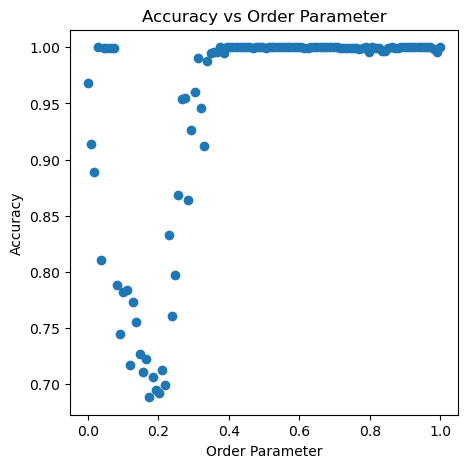

In [5]:

model_path = "C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\08_14_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_Off_High_Entrpoy_Homog_2024-08-14 12-24-10\\LifeGPT_epoch_50.pt"
max_length = len("@PredictNextState<> []$") + (32*32*2)
generate_length = max_length - len("@PredictNextState<>") - (32 * 32)

# Load the model
model = load_model(model_path, max_length, num_words=256)

# Initialize tokenizer
tokenizer = Tokenizer(max_length, device)

#Generate validation data (Assuming `conway_game` is defined elsewhere and imported)
val_size = 110  # Adjust this value as needed
s, e = 0, 1
gridwidth = 32
X_data_test_3, order_params_3 = generate_validation_data(gridwidth, conway_game, val_size, s, e)

# Test the model on validation data
results_3, overall_accuracy_3, accuracies_3 = test_model(model, tokenizer, X_data_test_3)

# Print the results and overall accuracy
for val, output, accuracy in results_3:
    print(f"Input: {val}\nOutput: {output}\nAccuracy: {accuracy}\n")

print(f"Overall Accuracy: {overall_accuracy_3}")

# Plot accuracy vs order parameter
plt.figure(figsize=(5, 5))
plt.scatter(order_params_3, accuracies_3)
plt.xlabel('Order Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Order Parameter')
plt.show()


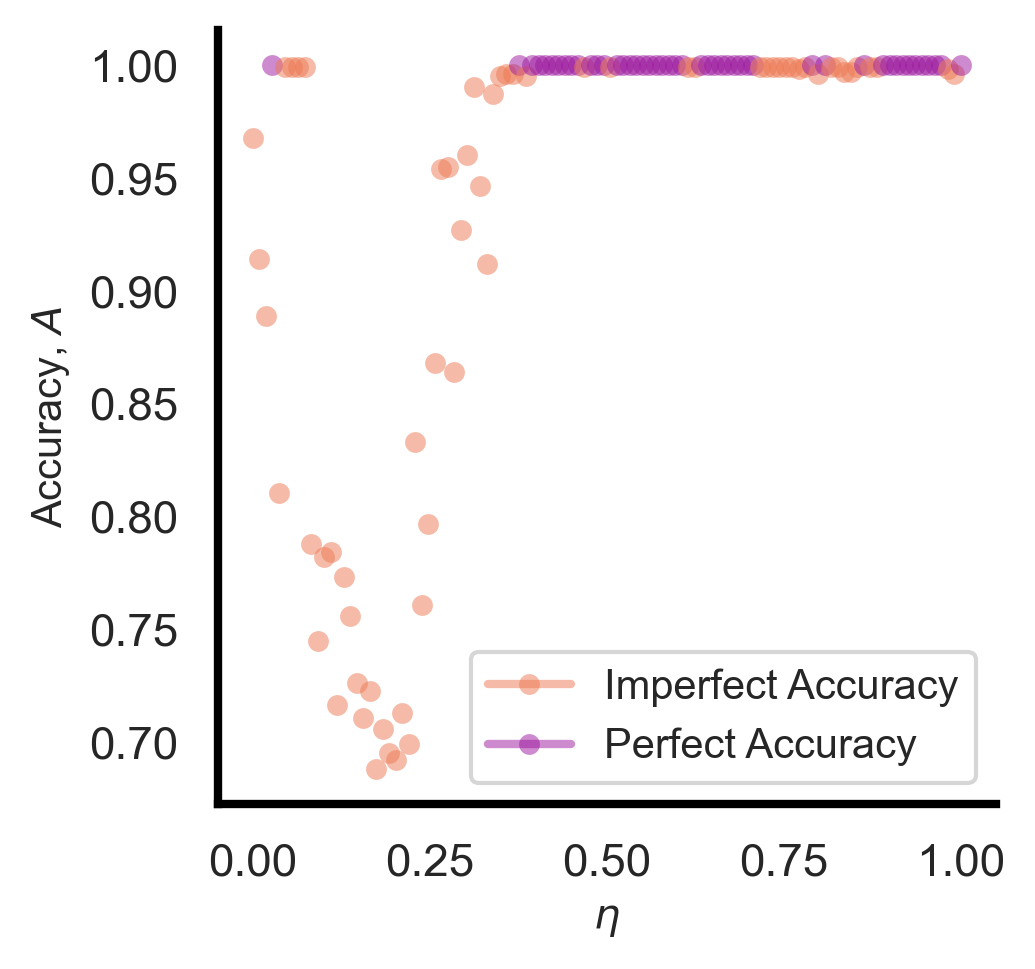

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a DataFrame for plotting
data = pd.DataFrame({'Order_Parameter': order_params_3, 'Accuracy': accuracies_3})

# Define the Plasma palette with 2 colors
plasma_palette = sns.color_palette("plasma", 2)

# Apply the style
sns.set(style="whitegrid", rc={
    'figure.figsize': (3.35, 3.35),
    'figure.dpi': 300,
    'lines.linewidth': 2.0,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'axes.grid': False
})

# Create the plot with two different colors based on accuracy and add to legend
plt.figure(figsize=(3.35, 3.35), dpi=300)
perfect_shown = False
imperfect_shown = False
for i, row in data.iterrows():
    if row['Accuracy'] == 1.0:
        plt.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[0], markersize=5, alpha=0.5, 
                 label='Perfect Accuracy' if not perfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        perfect_shown = True
    else:
        plt.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[1], markersize=5, alpha=0.5, 
                 label='Imperfect Accuracy' if not imperfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        imperfect_shown = True

plt.xlabel('$\eta$')
plt.ylabel('Accuracy, $A$')
plt.legend()
plt.show()


In [13]:
model_path = "C:\\Users\\jaime\\ML_Playground_1\\model_parameters\\07_22_2024__2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\\LifeGPT_epoch_50.pt"
max_length = len("@PredictNextState<> []$") + (32*32*2)
generate_length = max_length - len("@PredictNextState<>") - (32 * 32)

# Load the model
model = load_model(model_path, max_length, num_words=256)

# Initialize tokenizer
tokenizer = Tokenizer(max_length, device)

Model loaded from C:\Users\jaime\ML_Playground_1\model_parameters\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\Conway_GPT_v7_epoch_50.pt


In [14]:
# Test the model on validation data
results_4, overall_accuracy_4, accuracies_4 = test_model(model, tokenizer, X_data_test_3)

# Print the results and overall accuracy
for val, output, accuracy in results_4:
    print(f"Input: {val}\nOutput: {output}\nAccuracy: {accuracy}\n")

print(f"Overall Accuracy: {overall_accuracy_2}")

# Plot accuracy vs order parameter
plt.figure(figsize=(10, 5))
plt.scatter(order_params_3, accuracies_4)
plt.xlabel('Order Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Order Parameter')
plt.show()

1
Accuracy for val sample 1 is 1.0.
2
Accuracy for val sample 2 is 1.0.
3
Accuracy for val sample 3 is 1.0.
4
Accuracy for val sample 4 is 1.0.
5
Accuracy for val sample 5 is 1.0.
6
Accuracy for val sample 6 is 1.0.
7
Accuracy for val sample 7 is 1.0.
8
Accuracy for val sample 8 is 1.0.
9
Accuracy for val sample 9 is 1.0.
10
Accuracy for val sample 10 is 1.0.
11
Accuracy for val sample 11 is 1.0.
12
Accuracy for val sample 12 is 1.0.
13
Accuracy for val sample 13 is 1.0.
14
Accuracy for val sample 14 is 1.0.
15
Accuracy for val sample 15 is 1.0.
16
Accuracy for val sample 16 is 1.0.
17
Accuracy for val sample 17 is 1.0.
18
Accuracy for val sample 18 is 1.0.
19
Accuracy for val sample 19 is 1.0.
20
Accuracy for val sample 20 is 1.0.
21
Accuracy for val sample 21 is 1.0.
22
Accuracy for val sample 22 is 1.0.
23
Accuracy for val sample 23 is 1.0.
24
Accuracy for val sample 24 is 1.0.
25
Accuracy for val sample 25 is 1.0.
26
Accuracy for val sample 26 is 1.0.
27
Accuracy for val sample 27 

NameError: name 'overall_accuracy_2' is not defined

^ regarding the error above -- we never fixed this, as it did not affect the results themselves -- we used a different solution for visualization.

In [65]:
print(order_params_3[104])
print(results_4[104])

0.9541284403669725
('@PredictNextState<1111101111111111111111111111111111111110111111111111111111111111111111111111111110111111111111111011111111111101111111111111011111011111111111110111111111111110111111111111111011111111111111111111111111111110111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111011111011111111111111111111111111111111111111111111111011111111111111111111111111111111111111110111111111111111111111111011111111101111011111111111111111111111101111111111111111110111111111111111111111111111111111011111111111111111111111111111111111011111110111111111111111111111111111111111111111110111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111011111101111111111111111110111111111111110111111101011111111111111111111111111111110111111111111111111111111111111111111111111111101111111111111111111111111111111111101111

Overall Accuracy: 0.9999911221590909


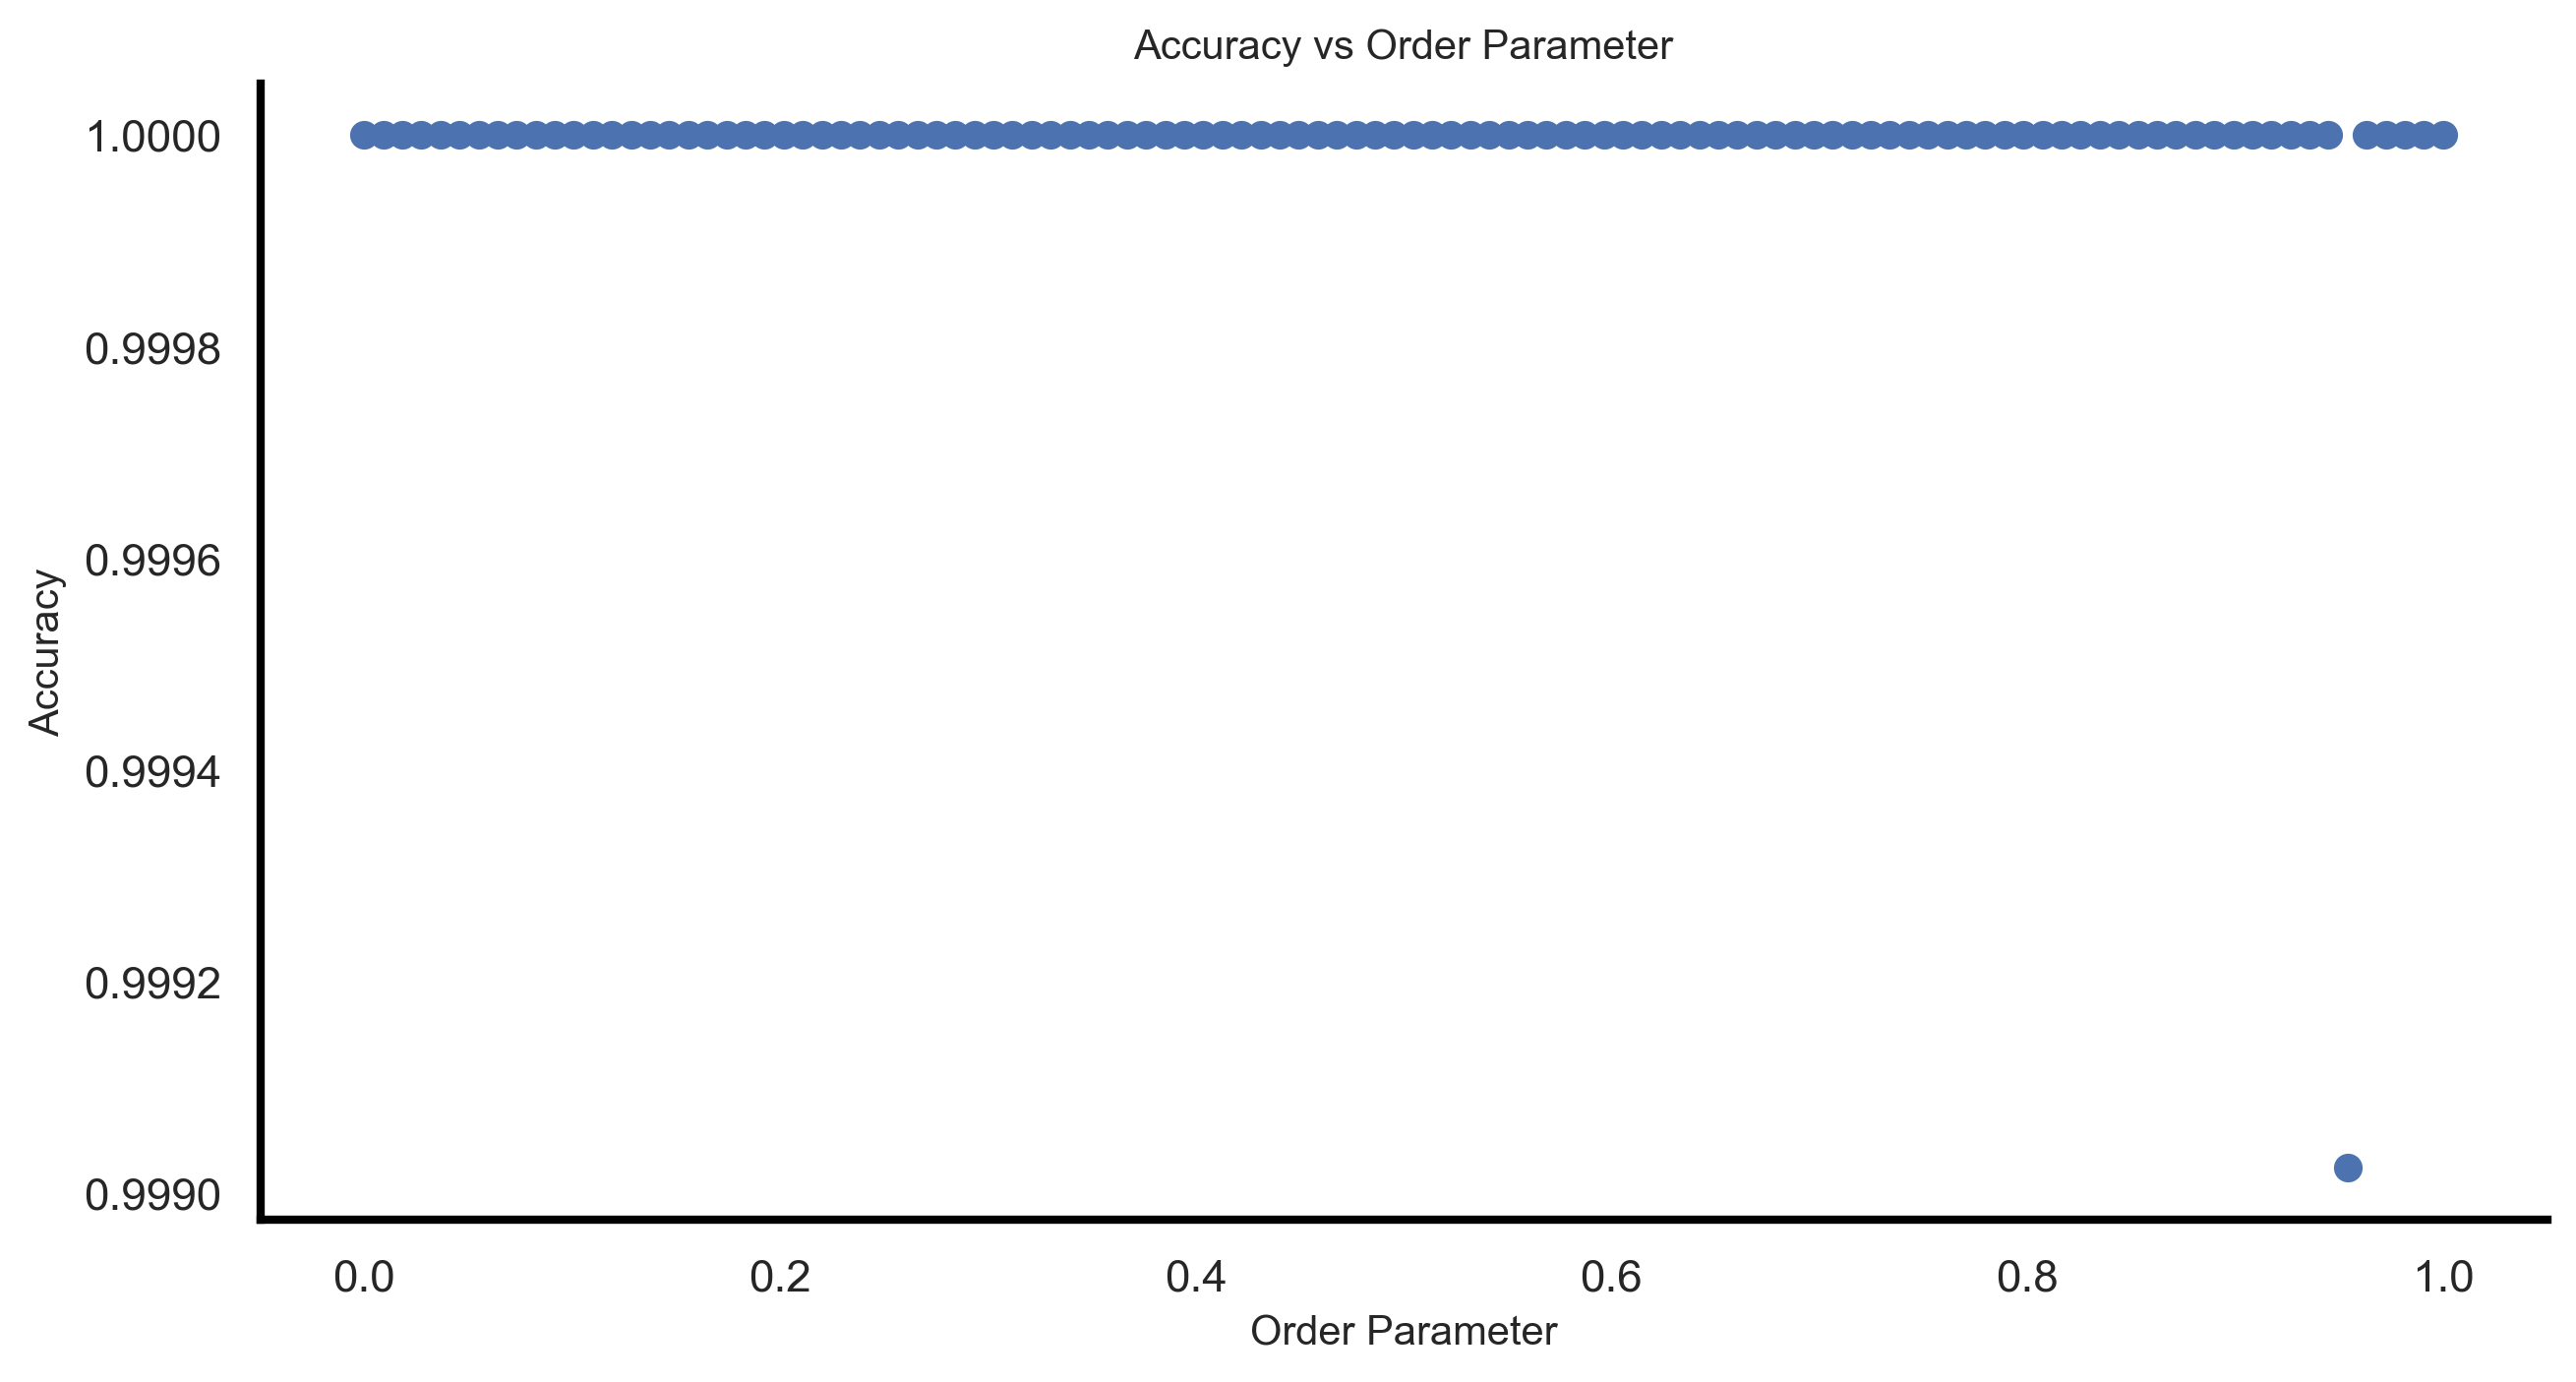

In [15]:
print(f"Overall Accuracy: {overall_accuracy_4}")

# Plot accuracy vs order parameter
plt.figure(figsize=(10, 5))
plt.scatter(order_params_3, accuracies_4)
plt.xlabel('Order Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Order Parameter')
plt.show()

C:\Users\jaime\AppData\Local\Temp\ipykernel_19412\60416734.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


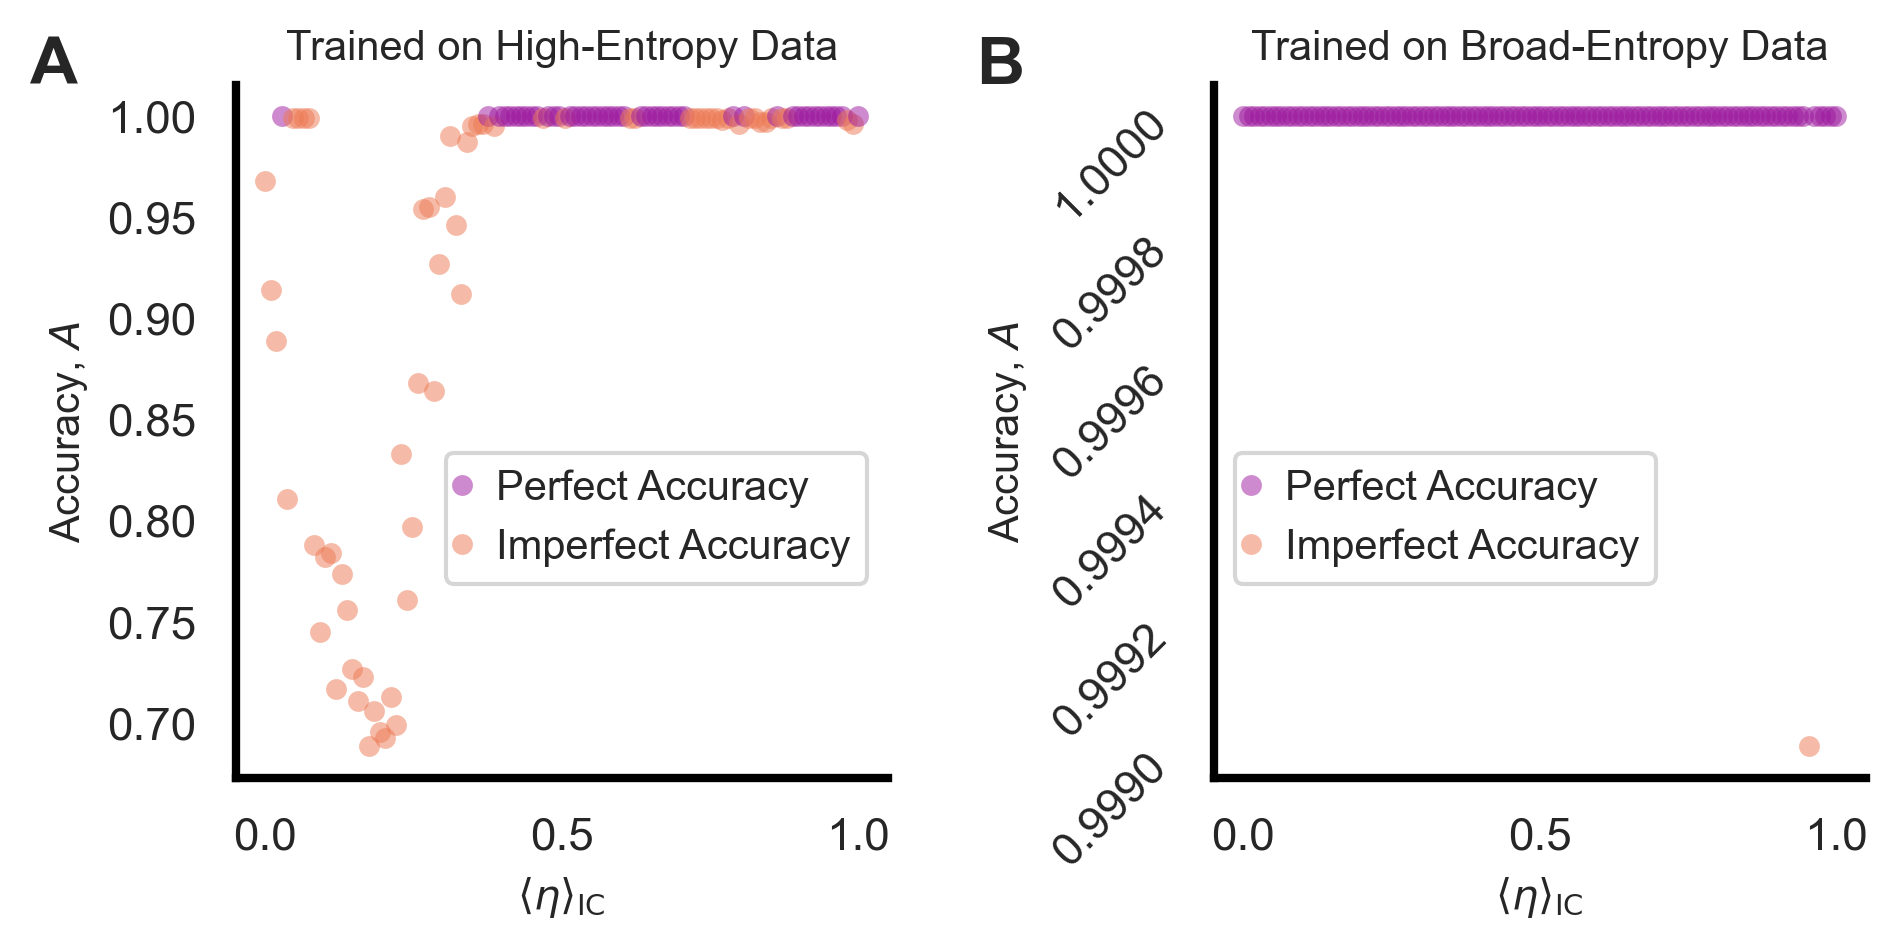

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plasma_palette = sns.color_palette("plasma", 2)

# Apply the style
sns.set(style="whitegrid", rc={
    'figure.figsize': (7.01, 3),
    'figure.dpi': 300,
    'lines.linewidth': 2.0,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'axes.grid': False
})

# Create the figure using GridSpec
fig = plt.figure(figsize=(7.01, 3), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plotting the first set of data
perfect_shown = False
imperfect_shown = False
for i, row in pd.DataFrame({'Order_Parameter': order_params_3, 'Accuracy': accuracies_3}).iterrows():
    if row['Accuracy'] == 1.0:
        ax1.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[0], markersize=5, alpha=0.5, 
                 label='Perfect Accuracy' if not perfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        perfect_shown = True
    else:
        ax1.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[1], markersize=5, alpha=0.5, 
                 label='Imperfect Accuracy' if not imperfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        imperfect_shown = True

ax1.set_xlabel('$\langle\eta\\rangle_{\mathrm{IC}}$')
ax1.set_ylabel('Accuracy, $A$')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc='lower right', bbox_to_anchor=(1, 0.25),handlelength=0)
ax1.set_title('Trained on High-Entropy Data')

# Plotting the second set of data
perfect_shown = False
imperfect_shown = False
for i, row in pd.DataFrame({'Order_Parameter': order_params_3, 'Accuracy': accuracies_4}).iterrows():
    if row['Accuracy'] == 1.0:
        ax2.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[0], markersize=5, alpha=0.5, 
                 label='Perfect Accuracy' if not perfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        perfect_shown = True
    else:
        ax2.plot(row['Order_Parameter'], row['Accuracy'], marker="o", color=plasma_palette[1], markersize=5, alpha=0.5, 
                 label='Imperfect Accuracy' if not imperfect_shown else "", markeredgewidth=2, markeredgecolor='none')
        imperfect_shown = True

ax2.set_xlabel('$\langle\eta\\rangle_{\mathrm{IC}}$')
ax2.set_ylabel('Accuracy, $A$')
ax2.legend(handlelength=0,loc='lower left', bbox_to_anchor=(0, 0.25))
ax2.set_title('Trained on Broad-Entropy Data')

fig.text(0.05, .9, 'A', fontsize=16, fontweight='bold', va='center', ha='right')
fig.text(0.5, .9, 'B', fontsize=16, fontweight='bold', va='center', ha='right')

# Rotate the tick labels on the x-axis for ax_inset
for label in ax2.get_yticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()
